# Atmospheric CO<sub>2</sub> Trends
**Author: Cayt Schlichting**<br>
*Audience: The Climate Curious*

**Project Goal:**  The goal of this notebook is to explore atmospheric CO<sub>2</sub> readings and perform time series forcasting to predict CO<sub>2</sub> levels in the future.  I will be using CO$_2$ readings from the Mauna Lao Observatory in Hawaii, which has the longest, directly-measured record of atmospheric CO$_2$ readings.



**Background:** 

**Carbon Dioxide (CO$_2$)** is a naturally occuring gas that exists in the earth's atmosphere.  Its concentration in the atmosphere is measured in "parts per million" or ppm.  There are many natural processes through which carbon dioxide enters and leaves the atmosphere.  Some common processes are through the breathing of animals and photosynthesis from plant life.  Carbon dioxide is an important part of our Earth's system as it is one of a subset of gases in our atmosphere that block outgoing heat - in the form of radiation.  This essentially bounces back heat that would normally radiate into space, creating a **greenhouse effect** that makes the Earth warm enough for us to live.

However, this is one of the cases where there can be **too much of a good thing**. As CO$_2$ is added to the atmosphere, the greenhouse effect increases, causing the average surface temperature of the earth to increase.  The sharp increase in CO$_2$ levels over the past century have been predominantly caused by humans.  In particular, our use of fossil fuels takes carbon that was stored deep in the earth's crust and releases it in the form of CO$_2$.   Reducing our CO$_2$ emissions (along with other greenhouse gas emissions) is crucial to preventing **climate degradation** - more commonly referred to as climate change or global warming.  



**How to read this report:**

<div class="alert alert-success"><b>Just want the highlights?</b> Check out the plots and these sections.</div>

<div class="alert alert-info"><b>Want more technical details?</b>  Start with these sections, but feel free to read through the code or jump out into the utils.py module and other notebooks for additional context.</div>


**Jump to Section:** &ensp;   [Acquisition and Prep](#acq-prep) - [Exploration](#explore) - [Modeling](#modeling) - [Summary](#ConclusionC88) - [References](#Ref)

In [1]:
#suppress warnings
import warnings
warnings.filterwarnings("ignore")

#Basics
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

#Viz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme(palette='colorblind')

#modeling and stats
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Modules
import utils

***
## Data Acquisition and Preparation  <a class="anchor" id="acq-prep" />
***

**Source:** [Scripps CO2 Program](https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html) - Mauna Loa Observatory, Hawaii <sup>[1](#1)</sup>

**Actions Taken:**
> - Pull only unadjusted monthly CO<sub>2</sub> readings.
> - Creates a datetime index and sorts it.
> - Drops any null months (data prior to May 1964)

<div class="alert alert-info">
    <b>Technical Notes:</b>
<ul>
  <li>While I originally planned to use daily readings, the metadata of the original dataset recommends using monthly values for analyzing long term variability.</li>
    <li>The authors provided additional CO<sub>2</sub> columns that removed seasonality and filled in missing values with a 4 harmonic fit with linear gain.  Since this project's goal is to explore seasonality and use modeling tools, I want to use the original dataset. Note, these readings are adjusted to the 2012 SIO manometric mole fraction scale.<sup><a href="https://scrippsco2.ucsd.edu/data/atmospheric_co2/scale_update_notice.html">2</a></sup></li>
  <li>Since this represents aggregated data from a given month, the dataset is originally stored with a datetime index set with the middle of each month.  Later, this will be resampled (moving the datetime to the end of the month) due to restrictions in statsmodel tools.</li>
</ul>
</div>

*Additional notes on data acquisition and preparations decisions can be found in wrangle.ipynb*

##### Acquire and Prepare

In [2]:
df = utils.get_co2_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 697 entries, 1964-05-15 to 2022-05-15
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      697 non-null    object 
 1   mn      697 non-null    object 
 2   co2     697 non-null    float64
dtypes: float64(1), object(2)
memory usage: 21.8+ KB


##### Splitting
*Using 40 years of data: 30 yr Train, 10 yr Test*

In [4]:
#Set start and middle points for train/test
start = 12*40 #40 years
middle = 12*10 #10 years
#Grab train
tr_eda = df.iloc[:-middle,:] #long version for eda
tr_mod = df.iloc[-start:-middle,:] #shortened version for modeling
#Get test
te = df.iloc[-(middle):,:]

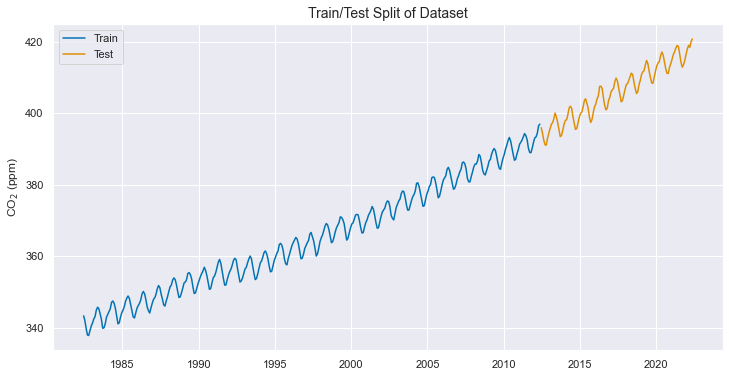

In [5]:
#Visualize the split
plt.figure(figsize=(12,6))
plt.plot(tr_mod.co2,label='Train'), plt.plot(te.co2,label='Test'), plt.legend(fontsize=14);
plt.title('Train/Test Split of Dataset',size=14); plt.ylabel('CO$_2$ (ppm)');

<div class="alert alert-success"><b>Notes:</b> In order to test our ability to forecast into the future, I first split off the last 10 years of data.  This will be used to see how well the modeling goes.</div>

***
## Exploration  <a class="anchor" id="explore" />
***
<div class="alert alert-success"><b>Questions I want to look at:</b>

- How have atmospheric CO$_2$ levels changed over time?
- What does the seasonal cycle of atmospheric CO$_2$ look like?
- How does a seasonal decomposition with statsmodel compare with other methods of pulling the seasonal cycle?
- Is there a trend in atmospheric CO$_2$ levels?
</div>

*More exploration can be found in explore_model.ipynb*

### Mauna Loa Observed Values

For this section, I seek to visually answer some questions about the data:
> - How have atmospheric CO$_2$ levels changed over time?
> - What does the seasonal cycle of atmospheric CO$_2$ look like?
> - Is there a trend in atmospheric CO$_2$ levels?

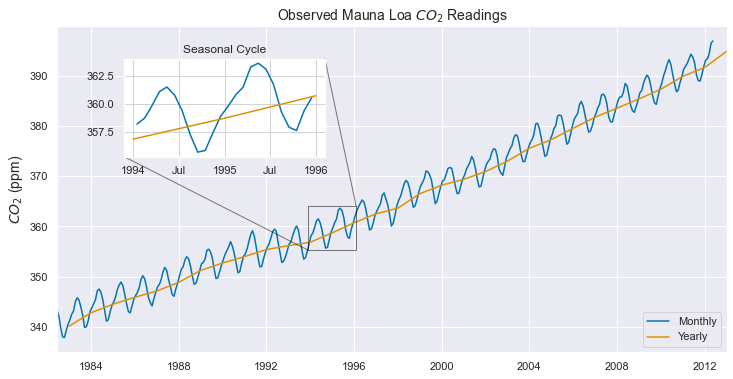

In [6]:
#Get yearly resampling
yrdf = tr_mod.resample('Y').mean()
#call inset plotting function
utils.mlo_inset_plot(tr_mod,yrdf)

<div class="alert alert-success"><b>Notes:</b> Looking at the above plot, we can see that atmospheric CO<sub>2</sub> readings have been increasing over time. The monthly data shows a distinct signal, whereas the yearly data smoothes out considerably and reveals an underlying trend.<br><br><b>Zooming in</b>, we can see a clear seasonal cycle with CO<sub>2</sub> appearing to peak at the start of summer and bottom out in the fall.<br><br> <b>Next,</b> let's pull out the seasonal variation and visualize that separately</div>

### Seasonal Decomposition 

For this section,  I want to visually answer these questions:
>  - What does the average seasonal cycle of atmospheric CO$_2$ look like?
>  - How does a seasonal decomposition with statsmodel compare with other methods of pulling the seasonal cycle?

##### Method 1 - Average monthly variance


In [7]:
#Create dataframe w/ average monthly reading
m1_season = pd.DataFrame(tr_mod.groupby('mn').co2.mean())
#rename that column
m1_season.rename(columns={'co2':'avg_co2'},inplace=True)
# Get monthly variance
m1_season['seas_var'] = m1_season.avg_co2 - tr_mod.co2.mean()
m1_season['mn'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

##### Method 2 - Using statsmodel.tsa.seasonal_decompose

In [8]:
#create the decomposition
decomp = sm.tsa.seasonal_decompose(tr_mod.co2,period=12)
#store pieces in dataframe
m2_season = pd.DataFrame({'y': decomp.observed,'trend': decomp.trend,
                          'seasonal': decomp.seasonal,'resid': decomp.resid})

##### Plot Seasonality

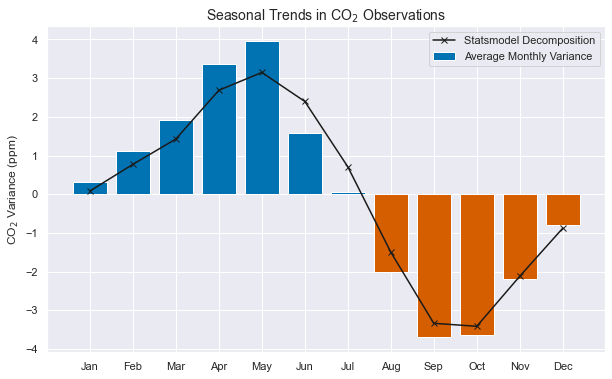

In [9]:
#Get random year we know has all months
last_full_year = str(tr_mod.index.year[-12])
#Plot seasonal variance
utils.plot_mlo_seasons(m1_season,m2_season,last_full_year)

<div class="alert alert-success"><b>Notes:</b> I used two methods to pull out the seasonal cycle and they both show a distinct seasonal pattern where the CO<sub>2</sub> observations are higher during the spring, then fall around 6 ppm over the summer until they bottom out in fall.  <br><br><b>Putting this in context of the earth system</b>, it makes sense as a representation of the earth <i>breathing</i>.  The Northern Hemisphere has much more land mass than the Southern Hemisphere.  During the Northern Hemisphere Summer, the majority of earth's plant life flourishes, resulting in a significant decrease in the atmospheric CO<sub>2</sub> as plants <i>inhale</i> CO<sub>2</sub> and <i>exhale</i> Oxygen.<br><br>You can read more about this process on <a href='https://www.nasa.gov/feature/goddard/carbon-climate'>NASA's website</a>.</div>

<div class="alert alert-info"><b>Technical Notes:</b> There are multiple ways of determining the seasonality in data.  Above, the bar plot shows the average monthly variance in CO<sub>2</sub> compared to the seasonal cycle calculated with statsmodel tools.  While the statsmodel is close, it appears to have troubles accelerating between the seasons (possibly due to using monthly samples).  Moving forward, method 1's seasonality will be used for manual seasonal adjustments in some of my modeling.</div>

***
## Modeling <a class="anchor" id="modeling" />
***   
<div class="alert alert-success"><b>Next,</b> I have created some models for predicting CO<sub>2</sub> levels into the future.  <br><br><b>Note:</b> These models do not look at current and future climate policies or CO<sub>2</sub> <i>emissions</i>.  The models predict future atmospheric CO<sub>2</sub> levels solely based off of past observations. </div>
    
<div class="alert alert-info"><b>Technical Notes:</b> The models will be evaluated using the root mean squeared error (RMSE).  The model that performs the best against the test data will be used to forecast future values.<br><br><i>In this section, I will show more of the underlying code for those of you that want a peak under the hood at the tools being used.</i></div>
    

### Time Series Analysis Performed - Technical Notes
> - ***Holt's Linear*** 
>  - Since there is clear seasonality in the dataset and this model doesn't account for that, the seasonality was removed prior to modeling, and readded into the results
>  - Optimized fit was used
> - ***Holt's Exponential*** 
>  - Since there is clear seasonality in the dataset and this model doesn't account for that, the seasonality was removed prior to modeling, and readded into the results
>  - Optimized fit was used
> - ***Holt-Winters Exponential Smoothing*** 
>  - Additive seasonality with 12 periods
>  - Additive trend with optimized fit was used

##### Create datasets w/ seasonality removed

In [10]:
#Merge seasonal variance into datasets
tr_mod = tr_mod.merge(m1_season[['seas_var']],how='left',on='mn').set_index(tr_mod.index)
te_pred = te.merge(m1_season[['seas_var']],how='left',on='mn').set_index(te.index)
#create adjusted column
tr_mod['co2_adj'] = tr_mod.co2 - tr_mod.seas_var
te_pred['co2_adj'] = te_pred.co2 - te_pred.seas_var

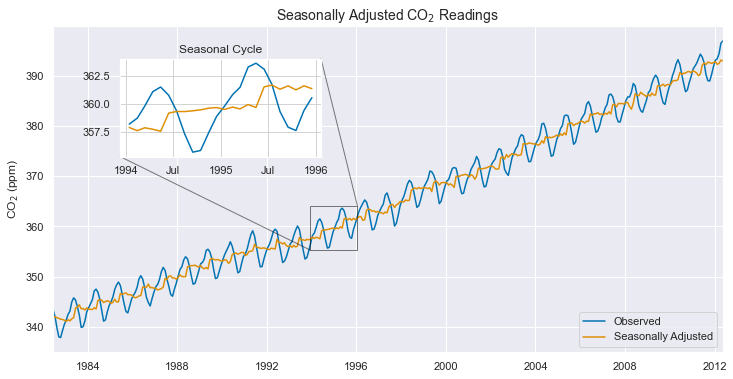

In [11]:
utils.mlo_adj_inset_plot(tr_mod,yrdf)

<div class="alert alert-success"><b>Above,</b> you can see what the seasonally adjusted data looks like [in orange]. While it clearly removed a significant amount of the seasonal signal, it is imperfect as there appears to be a remaining seasonal signal given the repeated steps occuring mid-year. </div>

In [12]:
#Statsmodel tools require frequency set in index
tr_mod_eom = tr_mod.resample('m').mean()
te_pred = te_pred.resample('m').mean()

##### Create Models and Test Predictions

In [13]:
#Holt's LINEAR - optimized - manual seasonality
h_linear = Holt(tr_mod_eom.co2_adj,exponential=False, damped_trend=False).fit(optimized=True)
#Holt's EXPONENTIAL - optimized - manual seasonality
h_exp = Holt(tr_mod_eom.co2_adj,exponential=True, damped_trend=False).fit(optimized=True)
#Holt's Winter's EXPOTENTIAL SMOOTHING - additive - optimized
hw_ExpSmooth = ExponentialSmoothing(tr_mod_eom.co2,trend='add',seasonal='add',seasonal_periods=12).fit(optimized=True)

#GET PREDICTIONS - add back in seasonality
te_pred['h_linear'] = h_linear.predict(start=te_pred.index[0],end=te_pred.index[-1])
te_pred['h_linear_w_seas'] = te_pred.h_linear + te_pred.seas_var

te_pred['h_exp'] = h_exp.predict(start=te_pred.index[0],end=te_pred.index[-1])
te_pred['h_exp_w_seas'] = te_pred.h_exp + te_pred.seas_var

te_pred['hw_ExpSmooth'] = hw_ExpSmooth.predict(start=te_pred.index[0],end=te_pred.index[-1])

##### Model Evaluation and Plotting

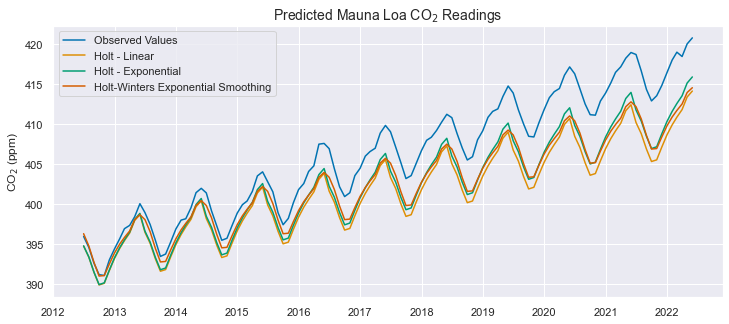


h_linear_w_seas model rmse: 4.95 (ppm)
Final year - rmse: 7.61 (ppm) - percent from actual: 1.83%
h_exp_w_seas model rmse: 4.01 (ppm)
Final year - rmse: 5.96 (ppm) - percent from actual: 1.43%
hw_ExpSmooth model rmse: 4.04 (ppm)
Final year - rmse: 6.4 (ppm) - percent from actual: 1.53%


In [14]:
#Plot the predicted values vs the observed values
utils.plot_models(te_pred),print() #extra line for spacing
#Loop over each model and evaluate
mods = ['h_linear_w_seas','h_exp_w_seas','hw_ExpSmooth']
for m in mods:
    #calculate RMSE, rmse for last 12 months and percent of observed value it represents
    rmse = round(sqrt(mean_squared_error(te_pred.co2,te_pred[m])),2)
    rmse_F = round(sqrt(mean_squared_error(te_pred.co2[-12:],te_pred[m][-12:])),2)
    perc = round((rmse_F / te_pred.co2[-12:].mean())*100,2)
    #print results
    print(f'\033[1m{m}\033[0m model rmse: {rmse} (ppm)')
    print(f'Final year - rmse: {rmse_F} (ppm) - percent from actual: {perc}%')

<div class="alert alert-success">As you can see above, they all had an rmse between 4 and 5 ppm.  However, you can tell how the error grows over time, so I also included the rmse for the final forecasted year as a comparison.  <b>The Holt's expontential model</b> with manual handling of seasonality performed the best on the test data and I will use this to forecast future CO<sub>2</sub> readings. That model was within 1.5% of the actual readings for the final year and I will use that information to inform error bands in the next section.</div>

<div class="alert alert-info"><b>Technical Notes:</b> Both models with exponential fits performed better than the linear model.  The manual seasonality and Holts-Winters calculated seasonality performed very similarly, with the manual seasonality with Holts-based prediction performing the best.
</div>

### Forecasting Future CO$_2$ Readings
##### Create dataset to be used for forecasting

In [15]:
#create forecasting dataset - use past 30 yrs
forecast = df[-360:]
#find seasonal means
f_seas = pd.DataFrame(forecast.groupby('mn').co2.mean())
f_seas.rename(columns={'co2':'avg_co2'},inplace=True)
#get monthly variance
f_seas['seas_var'] = f_seas.avg_co2 - forecast.co2.mean()
f_seas['mn'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#remove seasonality
forecast = forecast.merge(f_seas[['seas_var']],how='left',on='mn').set_index(forecast.index)
forecast['co2_adj'] = forecast.co2 - forecast.seas_var

#resample by month for modeling
forecast = forecast.resample('m').mean()

In [16]:
#start date is last value + 1 month. end date = start date + 15 years
startdate = forecast.index[-1] + pd.DateOffset(months=1)
enddate = startdate + pd.DateOffset(years=15)
#create empty dataframe w/ 10 year index
p_index = pd.date_range(start=startdate,end=enddate,freq='m')
predictions = pd.DataFrame(index=p_index)
#add in month for joining
predictions['mn'] = predictions.index.month.astype(str).str.zfill(2)
#join in seasonality
predictions = predictions.merge(f_seas[['seas_var']],how='left',on='mn').set_index(predictions.index)

###### Forecast

In [17]:
#MODELING
#Holt's EXPONENTIAL - optimized - manual seasonality
h_exp_f = Holt(forecast.co2_adj,exponential=True, damped_trend=False).fit(optimized=True)
#get predictions
predictions['pred'] = h_exp_f.predict(start=predictions.index[0],end=predictions.index[-1])
#add back in seasonality
predictions['pred_w_seas'] = predictions.pred + predictions.seas_var

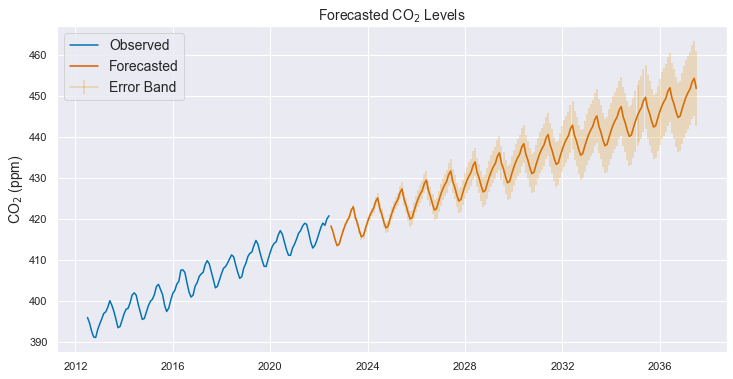

In [18]:
#PLOT
#Generate custom error bar
error = utils.get_custom_error(te_pred,predictions)
fig, ax = plt.subplots(figsize=(12,6))
#plot only 10 years of observed value
ax.plot(forecast.co2[-120:],label='Observed');
ax.errorbar(predictions.index,predictions.pred_w_seas, yerr=error,alpha=.3,color='#de8f05',label='Error Band');
ax.plot(predictions.pred_w_seas,label='Forecasted',color='#d55e00');
plt.legend(loc=2,fontsize=14), plt.title('Forecasted CO$_2$ Levels',size=14),plt.ylabel('CO$_2$ (ppm)',size=14);

<div class="alert alert-success"> My Holts exponential model predicts that given the current pace at which the atmospheric CO<sub>2</sub> levels are increasing, we can expect CO<sub>2</sub> levels to be above 450 ppm within 15 years.  The band seen around the forecasted data is the approximate error, which has been extrapolated from the performance of this model on the test dataset.</div>

***
## Summary <a class="anchor" id="ConclusionC88"></a>
***

<b>Goal Recap:</b> The goal of this notebook was to explore atmospheric CO2 readings and perform time series forcasting to predict CO2 levels in the future.

<b>Key Findings:</b>
> - The last 40 years of atmospheric CO$_2$ readings show a clear upward trend
> - There is a distinct seasonal pattern in the CO$_2$ readings, with a peak at the end of Spring and a trough in the Fall.  Annual readings can vary by 6 ppm
> - Modeling the time series, I was able to forecast 10 years with an rmse of 4 ppm.  Given that the error grew the farther the data was projected out, I extrapolated an error rate to be used on the future dataset.
> - Forecasting 15 years into the future, my model predicts that Earth will reach over 450 ppm by 2037.

<div class="alert alert-success"> 
<b>Why we care:</b> Global mean temperature has increased by approximately 1.1° Celsius.<sup>3</sup>  This is the expected warming based off of atmospheric CO$_2$ levels of above 350 ppm.  Earth's current level of 420 ppm means we can expect a significant temerature increase to already be baked in.  At the 450 ppm forecasted in this model for 2037, the IPCC predicts a global temperature increase of 2.1° Celsius.<sup>4</sup>
</div>

<b>Up Next:</b> We'll continue to explore climate data by looking at land and surface temperatures.

***
## References <a class="anchor" id="Ref" />
***

1. <a class="anchor" id="1"> </a> C. D. Keeling, S. C. Piper, R. B. Bacastow, M. Wahlen, T. P. Whorf, M. Heimann, and H. A. Meijer, Exchanges of atmospheric CO2 and 13CO2 with the terrestrial biosphere and oceans from 1978 to 2000.  I. Global aspects, SIO Reference Series, No. 01-06, Scripps Institution of Oceanography, San Diego, 88 pages, 2001. [Back](#acq-prep)

2. You can read more about the latest update to the 2012 scale [here](https://scrippsco2.ucsd.edu/data/atmospheric_co2/scale_update_notice.html)

3. <a class="anchor" id="3"> </a> This is a 1.1 degree increase from the baseline of 1951-1980.  See [NASA's earth observatory website](https://earthobservatory.nasa.gov/world-of-change/global-temperatures) for more details.

4. <a class="anchor" id="4"> </a> See Table 10.8 of the [Global Climate Projections](https://www.ipcc.ch/site/assets/uploads/2018/02/ar4-wg1-chapter10-1.pdf): <br>Meehl, G.A., T.F. Stocker, W.D. Collins, P. Friedlingstein, A.T. Gaye, J.M. Gregory, A. Kitoh, R. Knutti, J.M. Murphy, A. Noda, S.C.B. Raper, I.G. Watterson, A.J. Weaver and Z.-C. Zhao, 2007: Global Climate Projections. In: Climate Change 2007: The Physical Science Basis. Contribution of Working Group I to the Fourth Assessment Report of the Intergovernmental Panel on Climate Change [Solomon, S., D. Qin, M. Manning, Z. Chen, M. Marquis, K.B. Averyt, M. Tignor and H.L. Miller (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA.